<a href="https://colab.research.google.com/github/kashindra-mahato/SOC-support-system/blob/kashindra/authlog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 100
pd.set_option('display.precision', 3)

In [ ]:
auth = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASET/auth.csv')

In [ ]:
auth0 = auth[:1000]

In [ ]:
auth1 = auth0.copy()

In [ ]:
auth1.Event.head()

0               pam_unix(cron:session): session closed for user root
1    pam_unix(cron:session): session opened for user root by (uid=0)
2               pam_unix(cron:session): session closed for user root
3                      Connection closed by 122.225.103.87 [preauth]
4                      Connection closed by 122.225.103.87 [preauth]
Name: Event, dtype: object

In [ ]:
auth1.Event = auth1.Event.str.lower()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
# Remove numbers and special-characters from Event
auth1['Event'] = auth1['Event'].str.replace('\d+', '')
auth1['Event'] = auth1['Event'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [ ]:
# remove after 'user' including user :(
auth1['Event'] = auth1['Event'].apply(lambda x: x.split(' user ')[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
auth1.Event.head()

0    pam_unixcronsession session closed for
1    pam_unixcronsession session opened for
2    pam_unixcronsession session closed for
3             connection closed by  preauth
4             connection closed by  preauth
Name: Event, dtype: object

In [ ]:
# Remove stop words from Event
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

all_stopwords = stopwords.words('english')
all_stopwords.extend(['pam_unixcronsession', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth'])
auth1['Event'] = auth1['Event'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
auth1.Event.head(50)

0                                     session closed
1                                     session opened
2                                     session closed
3                                  connection closed
4                                  connection closed
5                                  connection closed
6                                     session opened
7                                     session closed
8                                     session opened
9                                     session closed
10                                           invalid
11                    input_userauth_request invalid
12                               received disconnect
13                            receive identification
14                                    session opened
15                                    session closed
16                            receive identification
17                                    session opened
18                                    session 

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


def build_vectorizer(sentences, vocab=None, min_df=0.0, max_df=1.0, ngram_range=(1,1)):
  # Build count vectorizer
  count_vectorzier = CountVectorizer(max_df=max_df, min_df=min_df,vocabulary=vocab, ngram_range=(1,1))
  cvec = count_vectorzier.fit(sentences)

  # Get feature names
  feature_names = cvec.get_feature_names_out()

  # Get bag-of-words and analyze
  bag_of_words = cvec.transform(sentences)
  df_bag_of_words = pd.DataFrame(bag_of_words.todense(),columns=feature_names)

  # Transform bag-of-words into tf-idf matrix
  transformer = TfidfTransformer()
  tfidf = transformer.fit_transform(bag_of_words)

  # Find most popular words and highest weights
  word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist() # for each word in column, sum all row counts
  df_cnts = pd.DataFrame({'word':feature_names, 'count':word_cnts})
  df_cnts = df_cnts.sort_values('count', ascending=False)

  # Build word weights as a list and sort them
  weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
  df_weights = pd.DataFrame({'word': feature_names,'weight':weights})
  df_weights = df_weights.sort_values('weight', ascending=False)

  df_weights = df_weights.merge(df_cnts, on='word', how='left')
  df_weights = df_weights[['word','count', 'weight']]

  # Cosine similarity of sentences
  cos_sim = cosine_similarity(tfidf,tfidf)

  # Distance matrix of sentences
  samp_dist = 1 - cos_sim

  return cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist


In [ ]:
sentences = auth1.Event[:1000]

In [ ]:
cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, sam_dist = build_vectorizer(sentences)

df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)
print(sentences)
print("---")
print("%d feature_names (each feature represent a distinct word)" %len(feature_names))
print(feature_names)
print("---")
print("df_tfidf[%d,%d]:"% (len(sentences), len(feature_names)))
# print(df_tfidf.to_string())
print("---")
print("df_weights:")
print(df_weights)
print("---")
print("cos_sim[%d,%d] (a sqaure matrix of length and width = len(sentences)):"%(len(sentences), len(sentences)))
print(cos_sim)

0              session closed
1              session opened
2              session closed
3           connection closed
4           connection closed
                ...          
995    receive identification
996    receive identification
997    receive identification
998    receive identification
999    receive identification
Name: Event, Length: 1000, dtype: object
---
35 feature_names (each feature represent a distinct word)
['address' 'attempt' 'breakin' 'cant' 'checking' 'client' 'closed'
 'connection' 'could' 'disconnect' 'failed' 'fatal' 'get' 'getaddrinfo'
 'ident' 'identification' 'input_userauth_request' 'internetsxcn'
 'invalid' 'mapping' 'nslocal' 'opened' 'peer' 'possible' 'read' 'receive'
 'received' 'reset' 'reverse' 'session' 'socket' 'telemarnetbr' 'unknown'
 'warning' 'write']
---
df_tfidf[1000,35]:
---
df_weights:
                      word  count     weight
0           identification    448  3.168e-01
1                  receive    448  3.168e-01
2                  

                      word  count     weight
0           identification    448  3.168e-01
1                  receive    448  3.168e-01
2                  invalid    230  1.858e-01
3               disconnect    147  1.039e-01
4                 received    147  1.039e-01
5   input_userauth_request    115  9.060e-02
6                   closed     45  3.234e-02
7                   failed    105  3.130e-02
8                  session     43  2.930e-02
9               connection     61  2.871e-02
10                 attempt     69  2.309e-02
11                 mapping     69  2.309e-02
12                checking     69  2.309e-02
13             getaddrinfo     69  2.309e-02
14                possible     69  2.309e-02
15                 breakin     69  2.309e-02
16                 reverse     69  2.309e-02
17            internetsxcn     65  2.224e-02
18                  opened     21  1.595e-02
19                   reset     38  1.468e-02
20                    peer     38  1.468e-02
21        

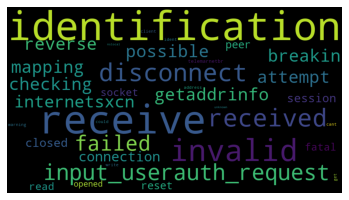

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
print(df_weights)
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

print("---")
print("di_word_freq:")
for k,v in di_word_freq.items():
  print(k,v)

cloud = WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# # Dimensionality reduction using PCA, reduce the tfidf matrix to just 2 features
# X = tfidf.todense()
# pca = PCA(n_components=2)
# pca.fit(X)
# X_pca = pca.transform(X)

# km_model = KMeans(n_clusters=3, max_iter=10, n_init=2, random_state=0)

# # K-means (from number of features in input matrix to n_clusters)
# km_model.fit(X_pca)
# df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

# plt.figure(figsize=(4,4))
# plt.suptitle('PCA features colored by class; grey circles show the k-means centers')
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_model.labels_, s=50, cmap='jet')
# plt.scatter(df_centers['x'], df_centers['y'], c='grey', s=500, alpha=0.2);

# dy = 0.04
# for i, txt in enumerate(km_model.labels_):
#     plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1] + dy))


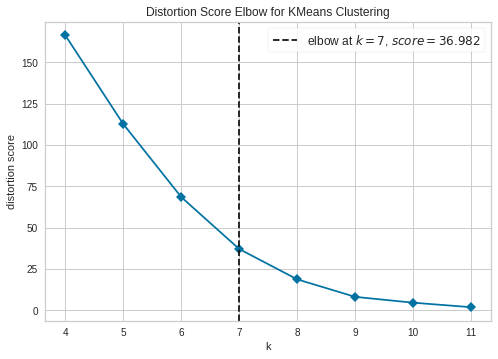

In [ ]:
# Elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)
X = tfidf.toarray()
visualizer.fit(X)
visualizer.show()

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.80)
pca.fit(X)
data_pca = pca.transform(X)

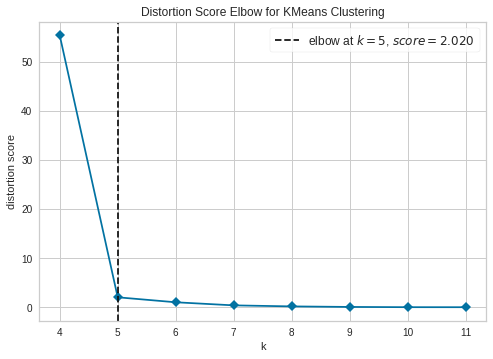

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)
visualizer.fit(data_pca)
visualizer.show()

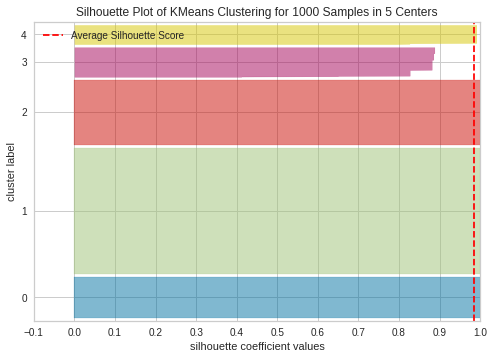

In [ ]:
# Silhouette method
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
model = KMeans(5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(data_pca)
visualizer.show()

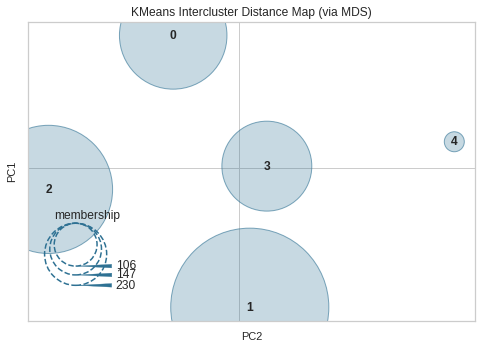

In [ ]:
# Intercluster Distance Maps
from yellowbrick.cluster.icdm import InterclusterDistance
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(data_pca)
visualizer.show()

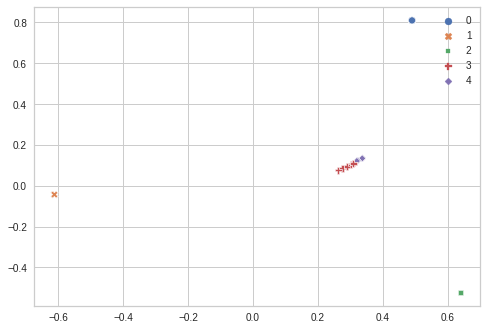

In [ ]:
import seaborn as sns
import plotly.express as px

model.fit(data_pca)
# df['y_pred'] = model.predict(data_pca)
fig = px.scatter(x=data_pca[:, 0], y=data_pca[:, 1])
fig.show()

sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=model.labels_,style=model.labels_,palette='deep',data=data_pca)


In [ ]:
df = auth0[:1000]

In [ ]:
df

,Unnamed: 0,Time,Hostname,Process,Event
0,0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882],pam_unix(cron:session): session closed for user root
1,1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session opened for user root by (uid=0)
2,2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session closed for user root
3,3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116],Connection closed by 122.225.103.87 [preauth]
4,4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118],Connection closed by 122.225.103.87 [preauth]
...,...,...,...,...,...
995,995,Dec 1 02:20:07,ip-172-31-27-153,sshd[23844],Did not receive identification string from 218.75.153.170
996,996,Dec 1 02:20:08,ip-172-31-27-153,sshd[23845],Did not receive identification string from 218.75.153.170
997,997,Dec 1 02:20:09,ip-172-31-27-153,sshd[23846],Did not receive identification string from 218.75.153.170
998,998,Dec 1 02:20:10,ip-172-31-27-153,sshd[23847],Did not receive identification string from 218.75.153.170


In [ ]:
df['y_pred'] = model.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
centroids = model.cluster_centers_

In [ ]:
# dict1 = dict(list(enumerate(centroids)))

In [ ]:
df_cent = pd.DataFrame(centroids)

In [ ]:
df_cent['label'] = [i for i in range(len(centroids))]

In [ ]:
data_pca

array([[ 0.30234058,  0.10318126,  0.36303052,  0.66358138],
       [ 0.28995007,  0.09465422,  0.30182116,  0.44790805],
       [ 0.30234058,  0.10318126,  0.36303052,  0.66358138],
       ...,
       [-0.61160647, -0.04309219, -0.04604159, -0.01587538],
       [-0.61160647, -0.04309219, -0.04604159, -0.01587538],
       [-0.61160647, -0.04309219, -0.04604159, -0.01587538]])

In [ ]:
df_data_pca = pd.DataFrame(data_pca)

In [ ]:
df_data_pca['label'] = model.predict(data_pca)

In [ ]:
df_data_pca

,0,1,2,3,label
0,0.302,0.103,0.363,0.664,3
1,0.290,0.095,0.302,0.448,3
2,0.302,0.103,0.363,0.664,3
3,0.303,0.104,0.380,0.677,3
4,0.303,0.104,0.380,0.677,3
...,...,...,...,...,...
995,-0.612,-0.043,-0.046,-0.016,1
996,-0.612,-0.043,-0.046,-0.016,1
997,-0.612,-0.043,-0.046,-0.016,1
998,-0.612,-0.043,-0.046,-0.016,1


In [ ]:
df_data_pca_join = df_data_pca.join(df_cent,on='label', how='left',lsuffix='_pca', rsuffix='_cent')

In [ ]:
df_data_pca_join

,0_pca,1_pca,2_pca,3_pca,label_pca,0_cent,1_cent,2_cent,3_cent,label_cent
0,0.302,0.103,0.363,0.664,3,0.301,0.103,0.384,0.557,3
1,0.290,0.095,0.302,0.448,3,0.301,0.103,0.384,0.557,3
2,0.302,0.103,0.363,0.664,3,0.301,0.103,0.384,0.557,3
3,0.303,0.104,0.380,0.677,3,0.301,0.103,0.384,0.557,3
4,0.303,0.104,0.380,0.677,3,0.301,0.103,0.384,0.557,3
...,...,...,...,...,...,...,...,...,...,...
995,-0.612,-0.043,-0.046,-0.016,1,-0.612,-0.043,-0.046,-0.016,1
996,-0.612,-0.043,-0.046,-0.016,1,-0.612,-0.043,-0.046,-0.016,1
997,-0.612,-0.043,-0.046,-0.016,1,-0.612,-0.043,-0.046,-0.016,1
998,-0.612,-0.043,-0.046,-0.016,1,-0.612,-0.043,-0.046,-0.016,1


In [ ]:
df_pca_1 = df_data_pca_join.loc[:, "0_pca":"label_pca"]
df_pca_1.drop('label_pca', axis=1, inplace=True)
df_cent_1 = df_data_pca_join.loc[:, "0_cent":"label_cent"]
df_cent_1.drop('label_cent', axis=1, inplace=True)

In [ ]:
display(df_pca_1)
display(df_cent_1)

,0_pca,1_pca,2_pca,3_pca
0,0.302,0.103,0.363,0.664
1,0.290,0.095,0.302,0.448
2,0.302,0.103,0.363,0.664
3,0.303,0.104,0.380,0.677
4,0.303,0.104,0.380,0.677
...,...,...,...,...
995,-0.612,-0.043,-0.046,-0.016
996,-0.612,-0.043,-0.046,-0.016
997,-0.612,-0.043,-0.046,-0.016
998,-0.612,-0.043,-0.046,-0.016


,0_cent,1_cent,2_cent,3_cent
0,0.301,0.103,0.384,0.557
1,0.301,0.103,0.384,0.557
2,0.301,0.103,0.384,0.557
3,0.301,0.103,0.384,0.557
4,0.301,0.103,0.384,0.557
...,...,...,...,...
995,-0.612,-0.043,-0.046,-0.016
996,-0.612,-0.043,-0.046,-0.016
997,-0.612,-0.043,-0.046,-0.016
998,-0.612,-0.043,-0.046,-0.016


In [ ]:
list1 = df_pca_1.to_numpy().tolist()
list2 = df_cent_1.to_numpy().tolist()

In [ ]:
from scipy.spatial import distance
distances = []
for i in range(len(list1)):
  dist = distance.euclidean(list1[i],list2[i])
  distances.append(dist)

In [ ]:
df['distance'] = distances

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df

,Unnamed: 0,Time,Hostname,Process,Event,y_pred,distance
0,0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882],pam_unix(cron:session): session closed for user root,3,1.081e-01
1,1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session opened for user root by (uid=0),3,1.375e-01
2,2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session closed for user root,3,1.081e-01
3,3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116],Connection closed by 122.225.103.87 [preauth],3,1.194e-01
4,4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118],Connection closed by 122.225.103.87 [preauth],3,1.194e-01
...,...,...,...,...,...,...,...
995,995,Dec 1 02:20:07,ip-172-31-27-153,sshd[23844],Did not receive identification string from 218.75.153.170,1,1.815e-16
996,996,Dec 1 02:20:08,ip-172-31-27-153,sshd[23845],Did not receive identification string from 218.75.153.170,1,1.815e-16
997,997,Dec 1 02:20:09,ip-172-31-27-153,sshd[23846],Did not receive identification string from 218.75.153.170,1,1.815e-16
998,998,Dec 1 02:20:10,ip-172-31-27-153,sshd[23847],Did not receive identification string from 218.75.153.170,1,1.815e-16


In [ ]:
def modified_zscore(data, consistency_correction=1.4826):
    
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

In [ ]:
mod_zscore, mad = modified_zscore(df['distance'])

In [ ]:
df['mod_zscore'] = mod_zscore.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df

,Unnamed: 0,Time,Hostname,Process,Event,y_pred,distance,mod_zscore
0,0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882],pam_unix(cron:session): session closed for user root,3,1.081e-01,1.071e+14
1,1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session opened for user root by (uid=0),3,1.375e-01,1.361e+14
2,2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session closed for user root,3,1.081e-01,1.071e+14
3,3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116],Connection closed by 122.225.103.87 [preauth],3,1.194e-01,1.182e+14
4,4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118],Connection closed by 122.225.103.87 [preauth],3,1.194e-01,1.182e+14
...,...,...,...,...,...,...,...,...
995,995,Dec 1 02:20:07,ip-172-31-27-153,sshd[23844],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01
996,996,Dec 1 02:20:08,ip-172-31-27-153,sshd[23845],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01
997,997,Dec 1 02:20:09,ip-172-31-27-153,sshd[23846],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01
998,998,Dec 1 02:20:10,ip-172-31-27-153,sshd[23847],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01


In [ ]:
def plot_anomaly(data, threshold):
    data = data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(data), len(data))
    mask_outliers = (data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], data[~mask_outliers],'o', color='b', label='normal')
    # plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Log Event', fontweight='bold')
    # plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Event')
    plt.ylabel('Modified z-score')
    plt.show()

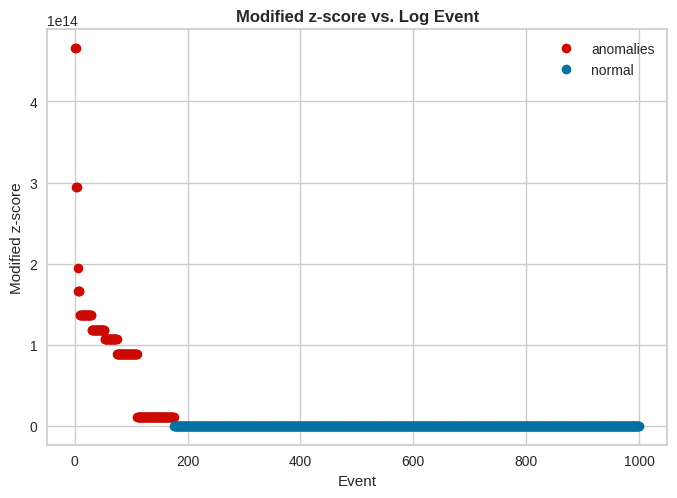

In [ ]:
plot_anomaly(df['mod_zscore'],3)

In [ ]:
df.loc[df.mod_zscore>3].Event.unique()

array(['pam_unix(cron:session): session closed for user root',
       'pam_unix(cron:session): session opened for user root by (uid=0)',
       'Connection closed by 122.225.103.87 [preauth]',
       'Connection closed by 122.225.109.208 [preauth]',
       'Connection closed by 122.225.109.123 [preauth]',
       'Connection closed by 218.2.0.129 [preauth]',
       'Connection closed by 218.2.0.121 [preauth]',
       'fatal: Read from socket failed: Connection reset by peer [preauth]',
       "warning: can't get client address: Connection reset by peer",
       'Could not write ident string to UNKNOWN',
       'Could not write ident string to 218.75.153.170',
       'reverse mapping checking getaddrinfo for 118.11.26.218.internet.sx.cn [218.26.11.118] failed - POSSIBLE BREAK-IN ATTEMPT!',
       'reverse mapping checking getaddrinfo for 18776080202.telemar.net.br [187.76.80.202] failed - POSSIBLE BREAK-IN ATTEMPT!',
       'reverse mapping checking getaddrinfo for ns.local [218.21.227.2

In [ ]:
df.loc[df.mod_zscore>3].mod_zscore

0      1.071e+14
1      1.361e+14
2      1.071e+14
3      1.182e+14
4      1.182e+14
         ...    
957    8.869e+13
965    8.869e+13
967    8.869e+13
978    8.869e+13
979    8.869e+13
Name: mod_zscore, Length: 175, dtype: float64

In [ ]:
df

,Unnamed: 0,Time,Hostname,Process,Event,y_pred,distance,mod_zscore
0,0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882],pam_unix(cron:session): session closed for user root,3,1.081e-01,1.071e+14
1,1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session opened for user root by (uid=0),3,1.375e-01,1.361e+14
2,2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session closed for user root,3,1.081e-01,1.071e+14
3,3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116],Connection closed by 122.225.103.87 [preauth],3,1.194e-01,1.182e+14
4,4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118],Connection closed by 122.225.103.87 [preauth],3,1.194e-01,1.182e+14
...,...,...,...,...,...,...,...,...
995,995,Dec 1 02:20:07,ip-172-31-27-153,sshd[23844],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01
996,996,Dec 1 02:20:08,ip-172-31-27-153,sshd[23845],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01
997,997,Dec 1 02:20:09,ip-172-31-27-153,sshd[23846],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01
998,998,Dec 1 02:20:10,ip-172-31-27-153,sshd[23847],Did not receive identification string from 218.75.153.170,1,1.815e-16,-6.745e-01


In [ ]:
df.loc[df.y_pred == 4].Event.unique()

array(['reverse mapping checking getaddrinfo for 118.11.26.218.internet.sx.cn [218.26.11.118] failed - POSSIBLE BREAK-IN ATTEMPT!',
       'reverse mapping checking getaddrinfo for 18776080202.telemar.net.br [187.76.80.202] failed - POSSIBLE BREAK-IN ATTEMPT!',
       'reverse mapping checking getaddrinfo for ns.local [218.21.227.251] failed - POSSIBLE BREAK-IN ATTEMPT!'],
      dtype=object)